# Analysis


1. Target --> Less than 8k param
2. Results --> Params: 7,544
3. Analysis --> Under-fitting (Test accuracy < Train accuracy)

Currently using dropout value of 0.05. Next iteration, we remove dropout.

In [1]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/ERA - Phase I/Session 7/

/content/gdrive/My Drive/ERA - Phase I/Session 7


In [3]:
!ls

data  model.py	__pycache__  README.md	S7_A.ipynb  utils.py


# Imports

In [4]:
from model import Net_A

In [5]:
import utils as utils

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Dataset, Transforms

In [7]:
device, use_cuda = utils.device()
print(f'CUDA Avialble? {use_cuda}')

CUDA Avialble? True


In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [9]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [10]:
batch_size = 64
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

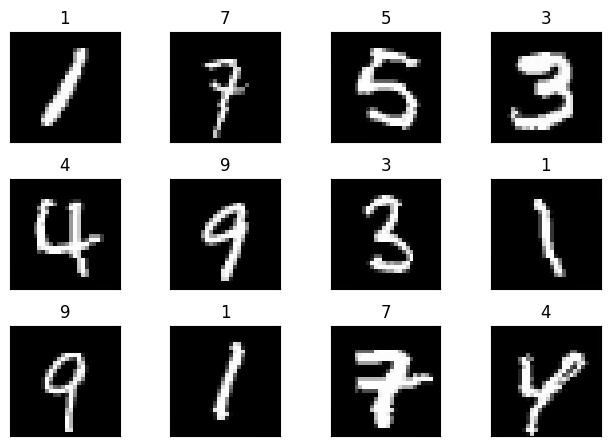

In [11]:
batch_data, batch_label = next(iter(train_loader))
utils.show_examples_dataset(batch_data, batch_label)

# Model

In [12]:
model = Net_A().to(device)
utils.show_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1, 16,

# Training

In [13]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [14]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.0165 Batch_id=937 Accuracy=91.87: 100%|██████████| 938/938 [00:27<00:00, 34.20it/s]


Test set: Average loss: 0.0529, Accuracy: 9833/10000 (98.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1276 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:26<00:00, 35.23it/s]


Test set: Average loss: 0.0412, Accuracy: 9875/10000 (98.75%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0051 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:26<00:00, 35.09it/s]


Test set: Average loss: 0.0372, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0863 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:30<00:00, 30.83it/s]


Test set: Average loss: 0.0328, Accuracy: 9889/10000 (98.89%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0627 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:27<00:00, 33.76it/s]


Test set: Average loss: 0.0274, Accuracy: 9922/10000 (99.22%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0193 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:27<00:00, 34.01it/s]


Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.1026 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:27<00:00, 34.45it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0217 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:27<00:00, 34.54it/s]


Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0762 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:26<00:00, 35.48it/s]


Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0012 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:25<00:00, 36.33it/s]


Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0024 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:26<00:00, 35.48it/s]


Test set: Average loss: 0.0213, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0129 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:27<00:00, 34.59it/s]


Test set: Average loss: 0.0223, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.1557 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:25<00:00, 36.35it/s]


Test set: Average loss: 0.0215, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0732 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:27<00:00, 33.97it/s]


Test set: Average loss: 0.0285, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0783 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:28<00:00, 33.15it/s]


Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-03.


# Results

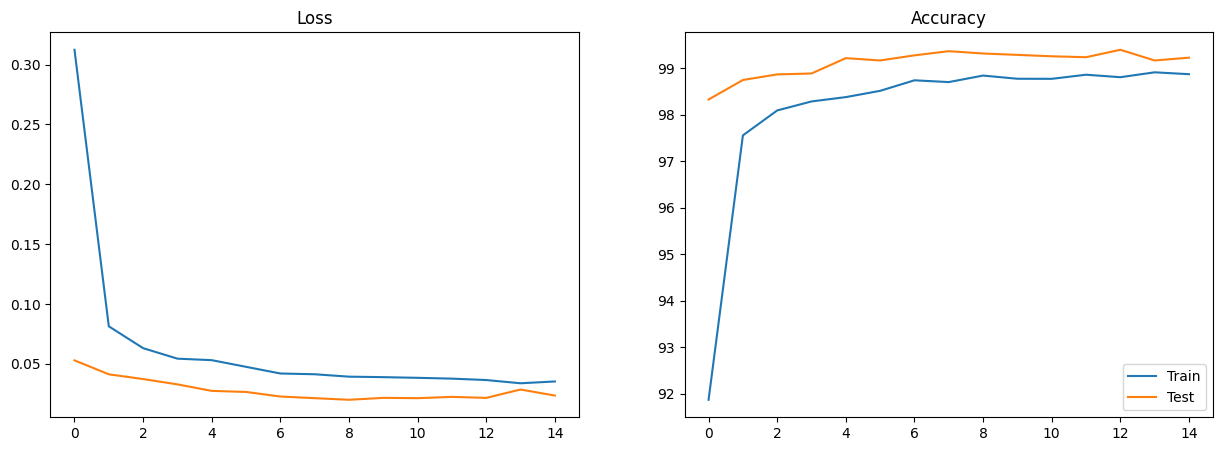

In [16]:
utils.plot_loss_accuracy([train_losses, test_losses, train_acc, test_acc])